In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import jax.numpy as jnp

import argparse
import os
import signal
import sys
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import itertools
import time

#-----------------------------------------------------
# Imports
import functools
import jax
import jax.tree_util as tree


from jaxopt import OptaxSolver
import pickle
from functools import partial
from jax import lax
import diffrax
from typing import Any, Callable, Dict, List, Optional, Tuple
import equinox as eqx
log_folder="runs"
# jax.config.update('jax_platform_name', 'cpu')

from torch.utils.tensorboard import SummaryWriter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


X (13, 9) N_Max (54, 1) hbarOmega (13,)
0.9839104615384615 0.7 -32.5 50 108.0
(13, 9, 1) (13, 9, 1) (54, 1) (13, 9) (9,)


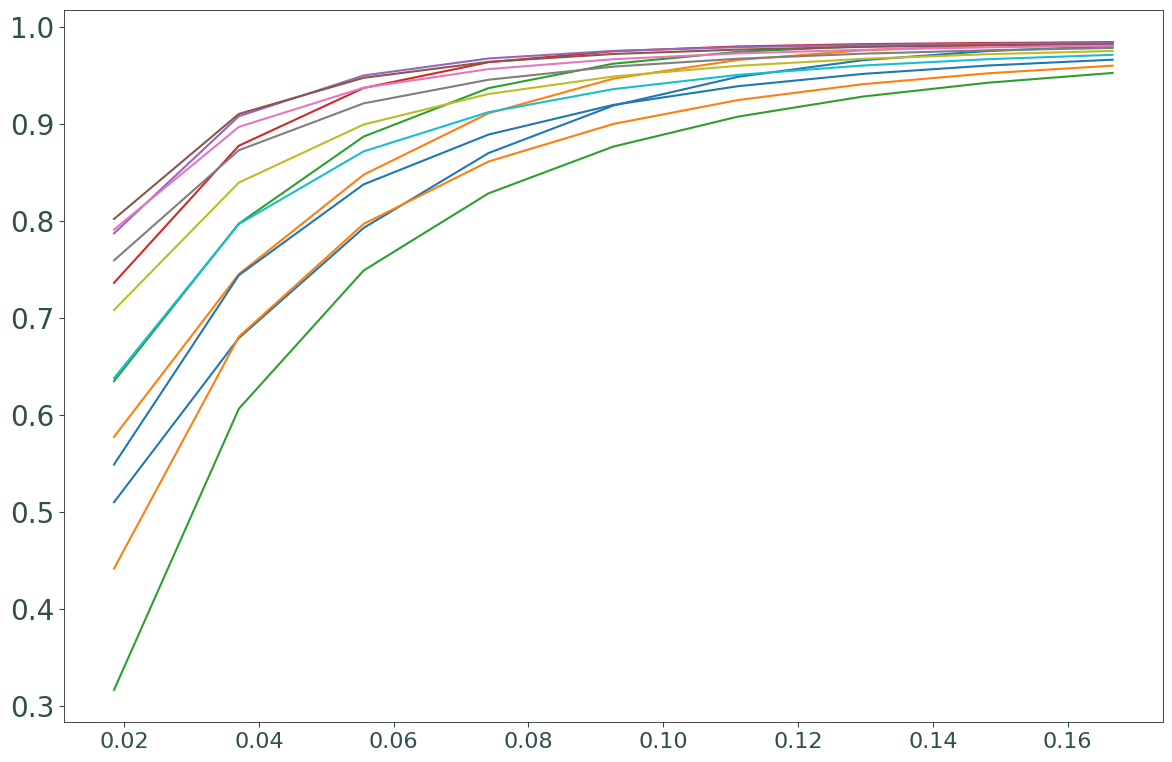

In [9]:
#-------------------------------------------------------
## Regular Linear layer in equinox
from model import *
from data import *
from utils import *
from trainer import *

N_Max_points      = 9
N_max_constraints = 20
hbaromega_choose  = 13
repeat=5
SEED=5678

X = np.load("data/processed_extrapolation.npy", allow_pickle=True)
ETr = X[()]["data"][:hbaromega_choose, 1:]
h_omega = X[()]["data"][:hbaromega_choose, 0]
N_Max = X[()]["Nmax"].reshape([-1])


ts_ = np.concatenate([N_Max + j * 18 for j in range(repeat + 1)], axis=0)
ts_ = np.vstack(ts_).astype(np.float32).reshape([-1, 1])

print("X", ETr.shape, "N_Max", ts_.shape, "hbarOmega", h_omega.shape)

#--------------------------------------------
# Normalizing factors
scale_gs = -32.5
scale_ho = 50
scale_Nmax = np.max(ts_)

#--------------------------------------------
# Normalize the dataset for efficiency
ts_  = ts_/scale_Nmax
x1 = (ETr/scale_gs)
x2 = h_omega/scale_ho


#--------------------------------------------
# Reverse Normalization
print(np.max(x1), np.max(x2), scale_gs, scale_ho, scale_Nmax )
# x1=x1*scale_gs
# x2=x2*scale_ho
# t=t*scale_Nmax
x2= jnp.expand_dims( jnp.expand_dims(x2, 1), 1)
x1= jnp.expand_dims( x1, 2)
x2 = jnp.repeat(x2, x1.shape[1], axis=1)
x = jnp.concatenate([x1, x2], axis =2)

# -----------------------------------------------------
print(x1.shape, x2.shape, ts_.shape, ETr.shape, N_Max.shape)
plt.figure()
[ plt.plot(ts_[0:9,:], x1[i,:]) for i in range(hbaromega_choose)]
# plt.plot(t, x1hat)
plt.show()

In [16]:
import jax.random as jr
#-----------------------------------------------------------
# with jax.default_device(jax.devices('cpu')[0]):
trainer = Trainer()
key = jax.random.PRNGKey(SEED)
data_key, model_key, loader_key = jr.split(key, 3)
#-----------------------------------------------------------
## Initialize the model
model = NeuralODE(data_size=2, width_size=128, depth=3, key=model_key)
model= eqx.tree_deserialise_leaves("MLP__Extrapolation_vdist13.eqx", model)

In [17]:

## Regular Linear layer in equinox
from model import *
from data import *
from utils import *
from trainer import *

#-------------------------------------------------------
BATCH_SIZE= 64
LEARNING_RATE = 3e-4
STEPS = 300
PRINT_EVERY = 30
SEED = 5678

    
#-------------------------------------------------------
## Running this code with the optax solver 
import jaxopt
import optax
import jax.random as jr

jax.config.update("jax_enable_x64", False)

def main(ts_, x, trainer, model, itrations, prints):
    params, static =  eqx.partition(model, eqx.is_array)
    #-----------------------------------------------------------
    # initialize the loss function
    func = trainer.return_loss_grad
    #-----------------------------------------------------------
    ## initialize the optimizer
    optim=OptaxSolver(opt=optax.adamw(1e-04), fun=func, value_and_grad=True, has_aux=True,\
        jit=False)
      
    #-----------------------------------------------------------
    params = trainer.train__EUC__( (ts_, x, 250, N_max_constraints, 1e-4),\
        params, static, optim, n_iter=itrations, print_iter=prints)
    model = eqx.combine(params, static)
    return trainer, model

#trainer, model = main(ts_, x, trainer, model, itrations=50, prints=1000)

In [18]:
#-----------------------------------------------
# x1=x1*scale_gs
# x2=x2*scale_ho
# ts_=ts_*scale_Nmax

#-----------------------------------------------
x0 = x[:,0,:]
print(x0.shape)
t=ts_.reshape([-1])
xhat = jax.vmap(model, in_axes=(None, 0))(t, x0)
        

#-----------------------------------------------
# x2=jnp.expand_dims( jnp.expand_dims(x2, 1), 1)
# x1=jnp.expand_dims( x1, 2)
# x2 = jnp.repeat(x2, x1.shape[1], axis=1)
# x = jnp.concatenate([x1, x2], axis =2)
# batch = (ts_.reshape([-1]), x[:,0,:], x, N_Max_points, N_max_constraints, hbaromega_choose)

(13, 2)


/var/folders/22/g5vqm_691y3dffxdf0vnnzvr0000gn/T/ipykernel_85139/1348843458.py:52: MatplotlibDeprecationWarning: Passing label as a length 13 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  [ plt.plot(ts_[0:9,:]*scale_Nmax, x1[i,:]*scale_gs, linestyle='-', c=colors[i], label=x[:,:,0]) for i in range(7)]
/var/folders/22/g5vqm_691y3dffxdf0vnnzvr0000gn/T/ipykernel_85139/1348843458.py:53: MatplotlibDeprecationWarning: Passing label as a length 13 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  [ plt.plot(ts_*scale_Nmax, xhat[i,:, 0]*scale_gs, linestyle='--',c=colors[i], label=x[:,:,0]) for i in range(7)]


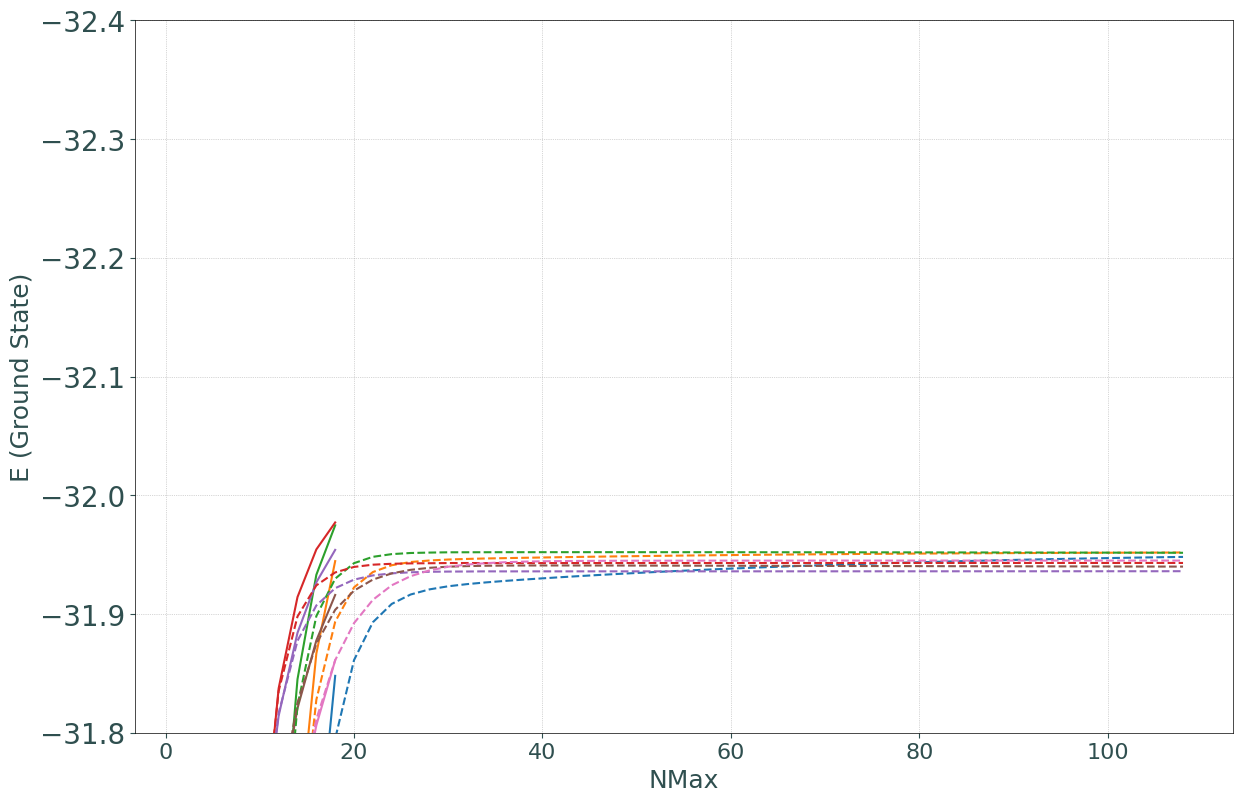

In [19]:

#-----------------------------------------------
# x1=x1*scale_gs
# x2=x2*scale_ho
# ts_=ts_*scale_Nmax

#-----------------------------------------------
x0 = x[:,0,:]
print(x0.shape)
t=ts_.reshape([-1])
xhat = jax.vmap(model, in_axes=(None, 0))(t, x0)
        

#-----------------------------------------------
# x2=jnp.expand_dims( jnp.expand_dims(x2, 1), 1)
# x1=jnp.expand_dims( x1, 2)
# x2 = jnp.repeat(x2, x1.shape[1], axis=1)
# x = jnp.concatenate([x1, x2], axis =2)
# batch = (ts_.reshape([-1]), x[:,0,:], x, N_Max_points, N_max_constraints, hbaromega_choose)
import seaborn as sns
sns.color_palette("bright")
large = 20; med = 18; small = 16
marker_size = 1.01
lw = 0.1
inten = 0.4
def cm2inch(value):
    return value/2.54
COLOR = 'darkslategray'
params = {'axes.titlesize': small,
        'legend.fontsize': small,
        'figure.figsize': (cm2inch(36),cm2inch(23.5)),
        'axes.labelsize': med,
        'axes.titlesize': small,
        'xtick.labelsize': small,
        'lines.markersize': marker_size,
        'ytick.labelsize': large,
        'figure.titlesize': large, 
            'text.color' : COLOR,
            'axes.labelcolor' : COLOR,
            'axes.linewidth' : 0.5,
            'xtick.color' : COLOR,
            'ytick.color' : COLOR}
colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
        "tab:cyan",
        "dodgerblue",
        "violet",
        "orangered",
        "maroon",
        "darkorange",
        "burlywood",
        "greenyellow",
        "tab:gray",
        "black",
        "rosybrown",
        "lightseagreen",
        "teal",
        "aqua",
        "darkolivegreen",
            ]

plt.rcParams.update(params)
plt.rc('text', usetex = False)
plt.figure()
[ plt.plot(ts_[0:9,:]*scale_Nmax, x1[i,:]*scale_gs, linestyle='-', c=colors[i], label=x[:,:,0]) for i in range(7)]
[ plt.plot(ts_*scale_Nmax, xhat[i,:, 0]*scale_gs, linestyle='--',c=colors[i], label=x[:,:,0]) for i in range(7)]
# plt.plot(t, x1hat)
# plt.xlim([0,1])
plt.ylim([-31.8,-32.4])
plt.xlabel('NMax')
plt.ylabel('E (Ground State)')
plt.grid(linestyle=':', linewidth=0.5)

plt.show()